<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm_univariate_timeseries_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pickle
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)

df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [135]:
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H")

# Train Test 

In [136]:
data =df.copy()

In [212]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]

In [137]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [138]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [139]:
def lstm_anomaly(df,col,date,time_step,threshold):
    print(f"{col}"+50*"*")
    df  = data.copy()
    df.set_index("Time",inplace=True)
    df1=df[[col]]
    train_size=len(df[df.index < date][col].tolist())
    test_size=df.shape[0]-train_size
    train, test = df1.iloc[0:train_size], df1[df1.index>"2020-01-13 15:00:00"]
    print(train.shape, test.shape)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])

    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl",scaler)    
           
    TIME_STEPS = time_step
    
    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train[[col]], train[col], TIME_STEPS)
    X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)

    print(X_train.shape)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
        
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,verbose=1
    )
   
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_anomaly_model.h5")
    X_train_pred = model.predict(X_train)

    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    
    X_test_pred = model.predict(X_test)

    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    
    THRESHOLD = threshold

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
    train_score_df['loss'] = train_mae_loss
    train_score_df['threshold'] = THRESHOLD
    train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
    train_score_df[col] = train[TIME_STEPS:][col]
    
    anomalies_train = train_score_df[train_score_df.anomaly == True]
    
    return anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler

In [140]:
def loss_and_threshold_value_plot():
    plt.plot(test_score_df.index, test_score_df.loss, label='loss_'+col)
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold_'+col)
    plt.xticks(rotation=25)
    plt.legend();

In [141]:
def train_mae_loss():
    sns.distplot(train_mae_loss, bins=50, kde=True);


In [246]:
def anomaly_plot(test,anomalies,col):
    ariza_tarihleri_plot= []
    for i in [str(a) for a in data["Time"]]:
          if i not in [str(b) for b in ariza_tarihleri]:
            ariza_tarihleri_plot.append(data[col].min())
          else:
            ariza_tarihleri_plot.append(data[col].max())
    ariza=pd.DataFrame(ariza_tarihleri_plot)
    ariza.index=data["Time"]
    ariza.columns=["ariza tarihleri"]

    print(anomalies.head(10))
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.plot(ariza["ariza tarihleri"],label="ariza tarihleri")
    plt.xticks(rotation=25)
    plt.legend();


In [214]:
def loss_plot():
    plt.plot(history.history['loss'], label='train loss_'+col)
    plt.plot(history.history['val_loss'], label='test loss_'+col)
    plt.legend();


In [215]:
total_anomalies = pd.DataFrame()


# vibx 

In [261]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibx",date="2021-01-10 04:00:00", time_step=20, threshold=2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibx**************************************************
(7997, 1) (8009, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(7977, 20, 1)
Epoch 1/50
225/225 [==============================] - 7s 21ms/step - loss: 0.1895 - val_loss: 0.1014
Epoch 2/50
225/225 [==============================] - 4s 18ms/step - loss: 0.1270 - val_loss: 0.0978
Epoch 3/50
225/225 [==============================] - 4s 18ms/step - loss: 0.1185 - val_loss: 0.0978
Epoch 4/50
225/225 [==============================] - 4s 17ms/step - loss: 0.1141 - val_loss: 0.0987
Epoch 5/50
225/225 [==============================] - 4s 17ms/step - loss: 0.1114 - val_loss: 0.0935
Epoch 6/50
225/225 [==============================] - 4s 18ms/step - loss: 0.1089 - val_loss: 0.0960
Epoch 7/50
225/225 [==============================] - 4s 17ms/step - loss: 0.1072 - val_loss: 0.0942
Epoch 8/50
225/225 [==============================] - 4s 18ms/step - loss: 0.1066 - val_loss: 0.1020
Epoch 9/50
225/225 [==============================] - 4s 17ms/step - loss: 0.1106 - val_loss: 0.0923
Epoch 10/50
225/225 [==============================] - 4s 18ms/step - loss: 0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


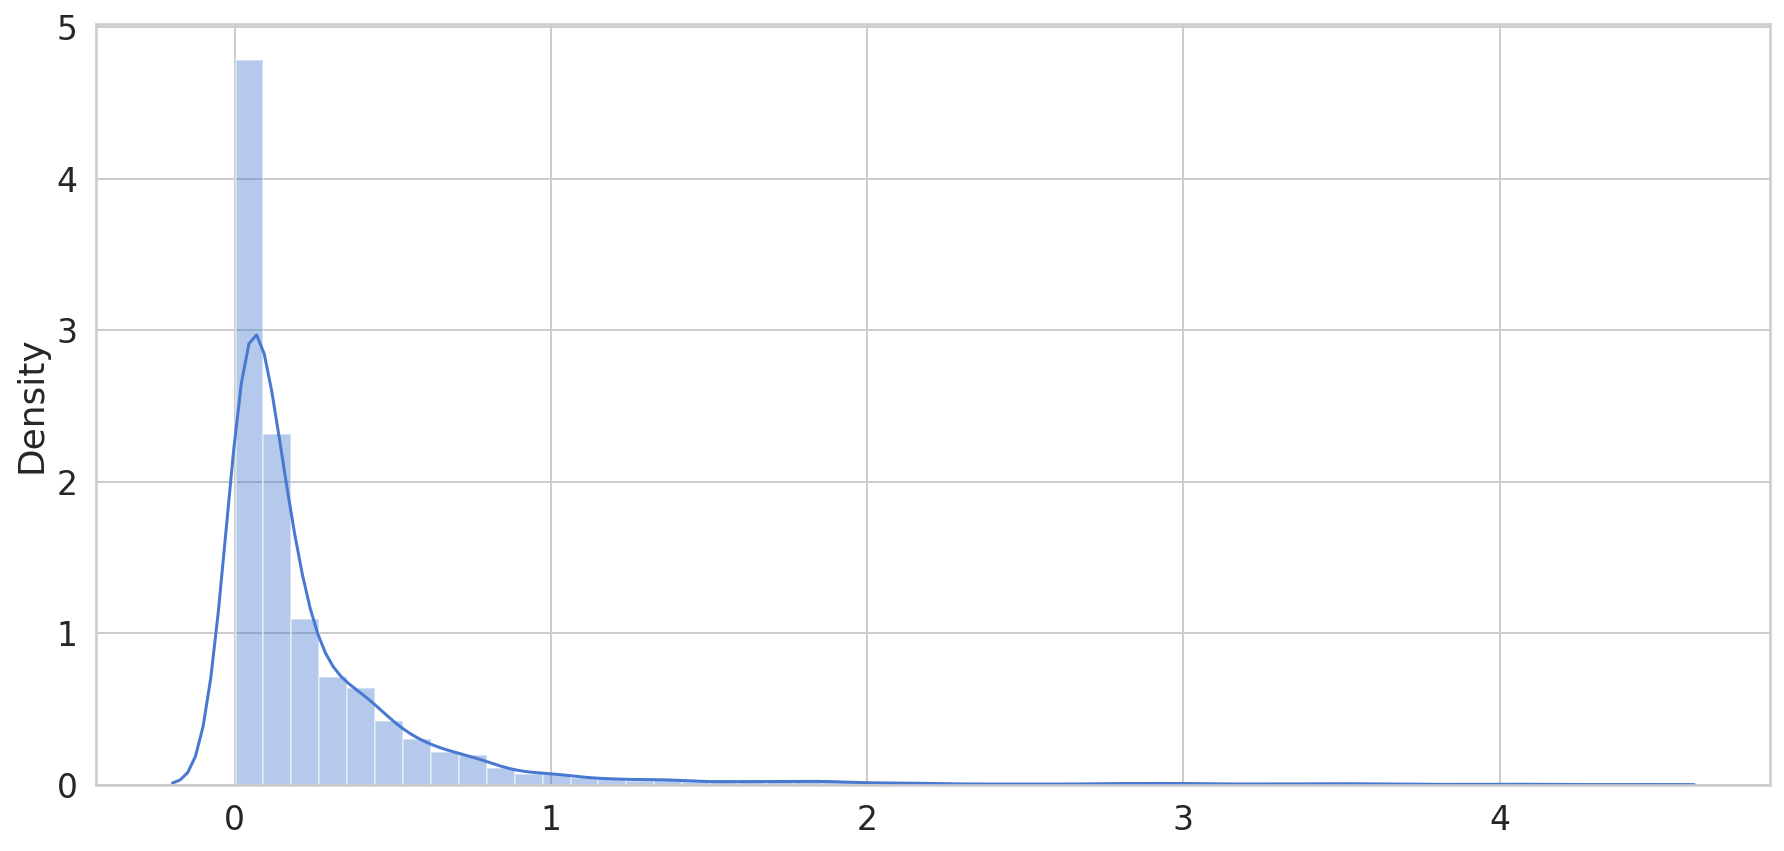

In [262]:
sns.distplot(train_mae_loss, bins=50, kde=True)

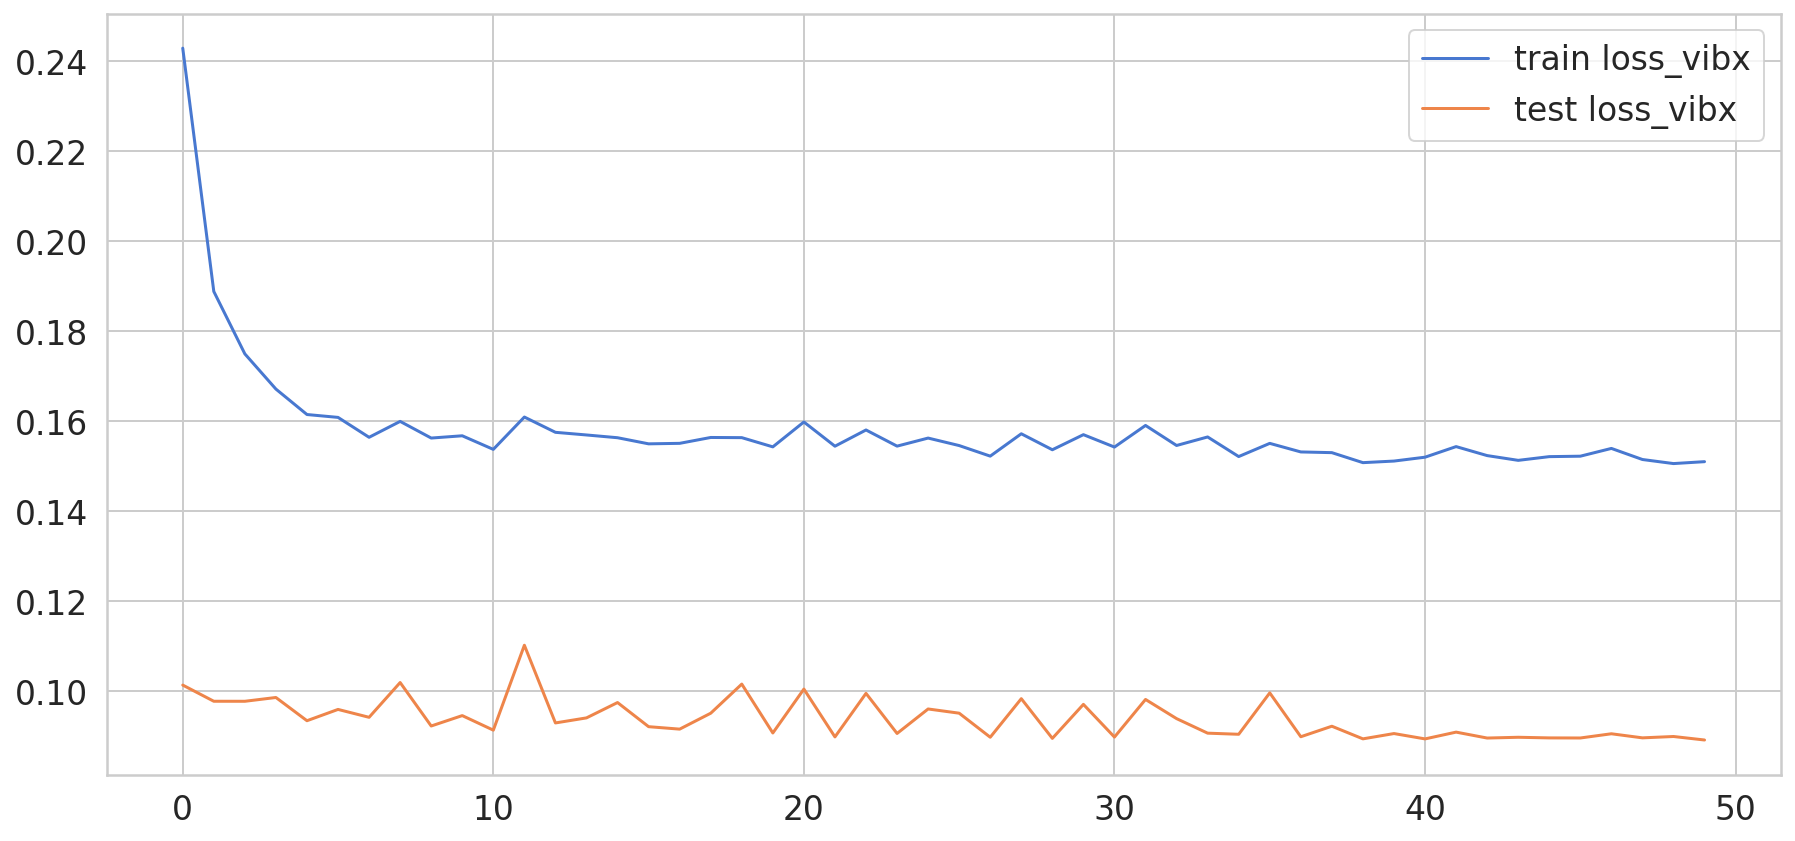

In [263]:
loss_plot()

                         loss  threshold  anomaly      vibx
Time                                                       
2020-09-12 13:00:00  2.024537          2     True  1.482990
2020-09-12 21:00:00  2.449829          2     True  5.393376
2020-09-12 22:00:00  3.455284          2     True  5.004444
2020-09-12 23:00:00  3.331449          2     True  3.911342
2020-09-13 00:00:00  2.384450          2     True  3.136159
2020-09-13 14:00:00  2.742793          2     True -0.861557
2020-09-13 15:00:00  3.501302          2     True -0.864012
2020-09-13 16:00:00  3.468185          2     True -0.860927
2020-09-13 17:00:00  3.198516          2     True -0.861199
2020-09-13 18:00:00  2.881011          2     True -0.833499


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


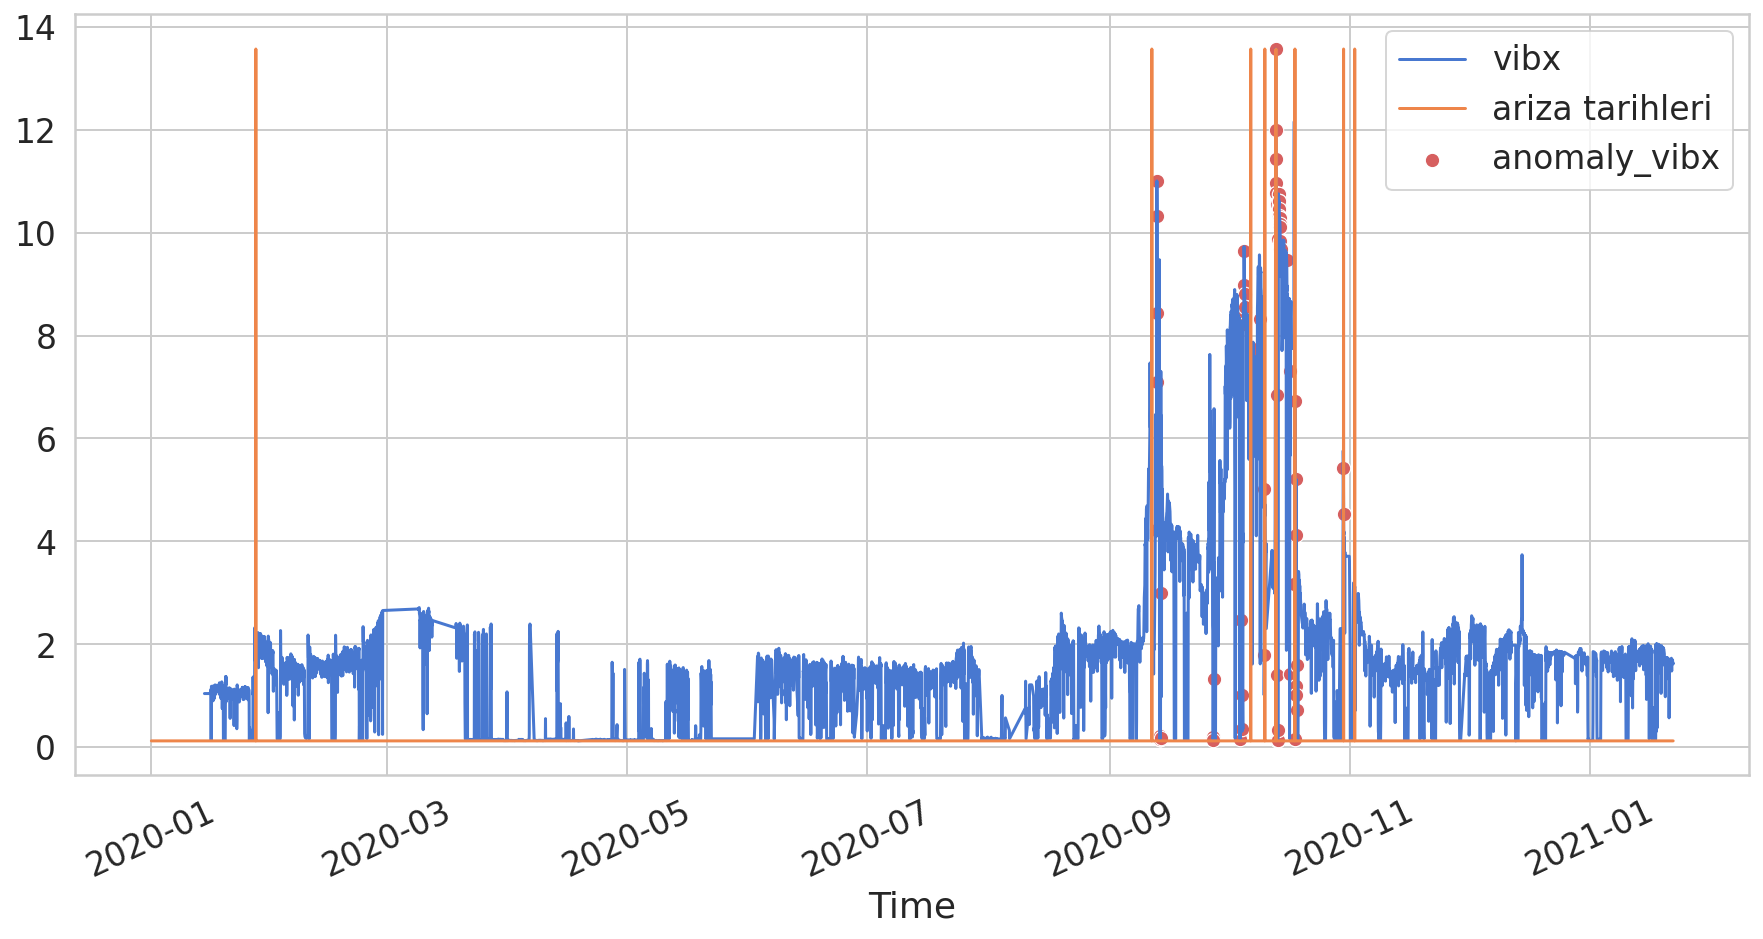

In [265]:
anomaly_plot(test,anomalies=anomalies,col="vibx")

# vibz

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibz",date="2021-01-10 04:00:00",time_step=20,threshold=2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibz**************************************************
(7997, 1) (8009, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(7977, 20, 1)
Epoch 1/50
225/225 [==============================] - 8s 23ms/step - loss: 0.1461 - val_loss: 0.1017
Epoch 2/50
225/225 [==============================] - 4s 18ms/step - loss: 0.1018 - val_loss: 0.1039
Epoch 3/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0954 - val_loss: 0.0975
Epoch 4/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0906 - val_loss: 0.0979
Epoch 5/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0876 - val_loss: 0.0956
Epoch 6/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0863 - val_loss: 0.0961
Epoch 7/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0856 - val_loss: 0.0981
Epoch 8/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0860 - val_loss: 0.0938
Epoch 9/50
225/225 [==============================] - 4s 18ms/step - loss: 0.0860 - val_loss: 0.1001
Epoch 10/50
225/225 [==============================] - 4s 18ms/step - loss: 0

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="vibz")

# temp

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="temp",date="2021-01-10 04:00:00",time_step=20,threshold=2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="temp")

# zacc

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zacc",date="2021-01-10 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="zacc")

# crest

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="crest",date="2021-01-10 04:00:00",time_step=20,threshold=1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="crest")

# zfreq

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zfreq",date="2021-01-10 04:00:00",time_step=20,threshold=4)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies)

In [ ]:
total_anomalies.groupby("Time")["anomaly_count"].sum().plot()

In [ ]:
total_anomalies["Time"].value_counts()

In [ ]:
total_anomalies.to_csv("total_anomaly.csv")